In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Fake News Prediction/News.csv')
data.head()

,Unnamed: 0,title,text,subject,date,class
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [4]:
data.shape

(44919, 6)

In [5]:
data = data.drop(["title", "subject","date","Unnamed: 0"], axis = 1)

In [6]:
data.isnull().sum()

,0
text,0
class,0


In [7]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='class', ylabel='count'>

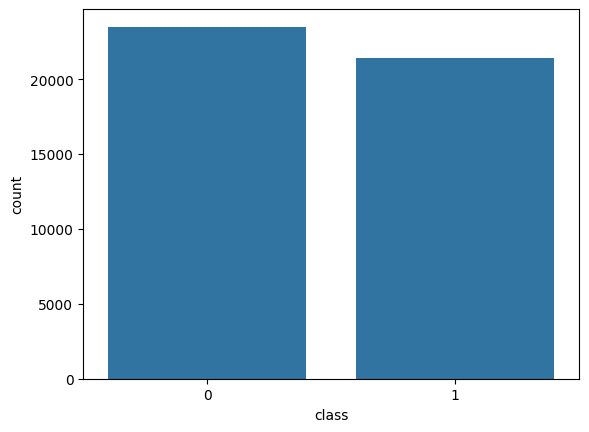

In [8]:
sns.countplot(data=data,
			x='class',
			order=data['class'].value_counts().index)

In [9]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))
	return preprocessed_text

In [11]:
preprocessed_review = preprocess_text(data['text'].values)
data['cleaned_text'] = preprocessed_review

100%|██████████| 44919/44919 [21:58<00:00, 34.06it/s]


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44919 entries, 0 to 44918
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          44919 non-null  object
 1   class         44919 non-null  int64 
 2   cleaned_text  44919 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


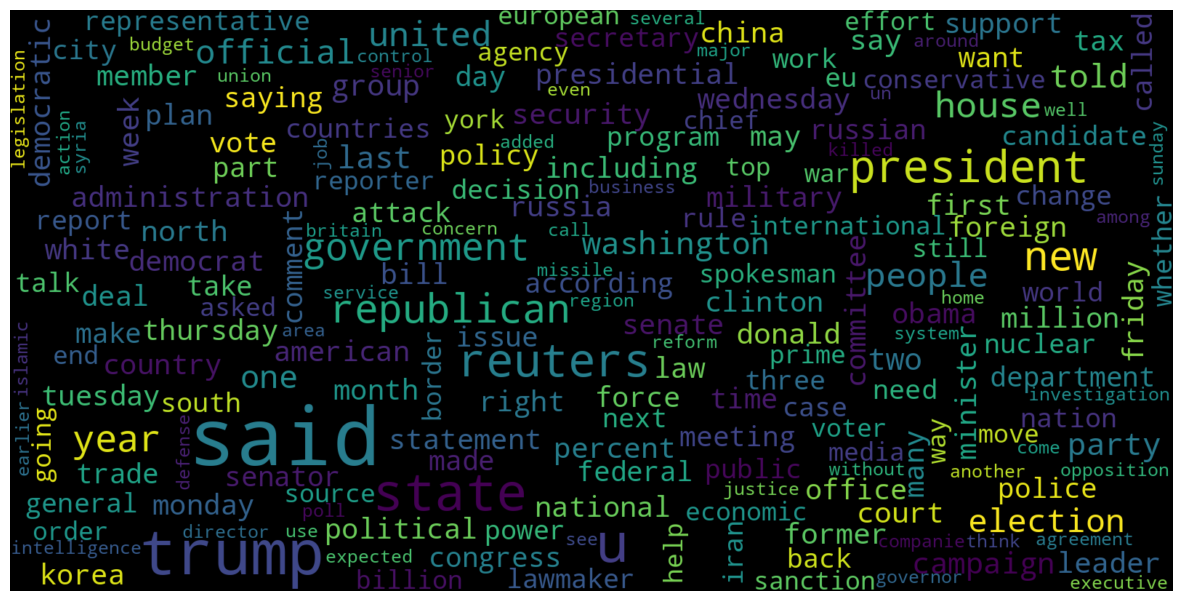

In [13]:
# Real
real = ' '.join(
	word for word in data['cleaned_text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(real), interpolation='bilinear')
plt.axis('off')
plt.show()

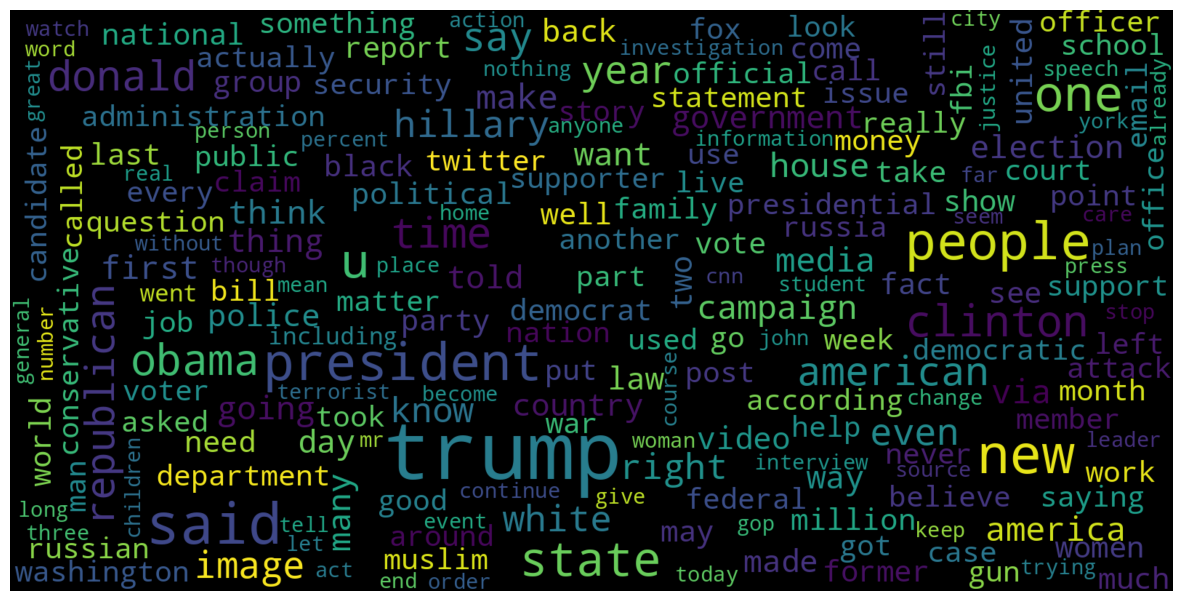

In [14]:
# Fake
fake = ' '.join(
	word for word in data['cleaned_text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
					height=800,
					random_state=21,
					max_font_size=110,
					collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(fake), interpolation='hamming')
plt.axis('off')
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
x_train, x_test, y_train, y_test = train_test_split(data['cleaned_text'],
													data['class'],
													test_size=0.25)

In [16]:
x_train = x_train.fillna('')
x_test = x_test.fillna('')

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [18]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(x_train, y_train)
acc_nb=accuracy_score(y_test, model.predict(x_test))
print(acc_nb)

0.9522707034728406


In [19]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
acc_dt=accuracy_score(y_test, model.predict(x_test))
print(acc_dt)

0.996260017809439


In [20]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300,max_depth=10,min_samples_split=5)
model.fit(x_train, y_train)
acc_rf=accuracy_score(y_test, model.predict(x_test))
print(acc_rf)

0.9813891362422084


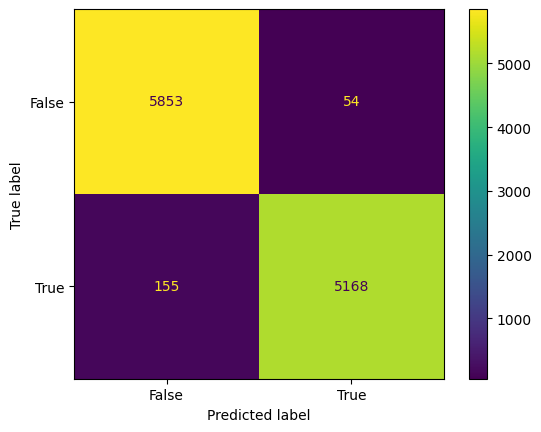

In [21]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])
cm_display.plot()

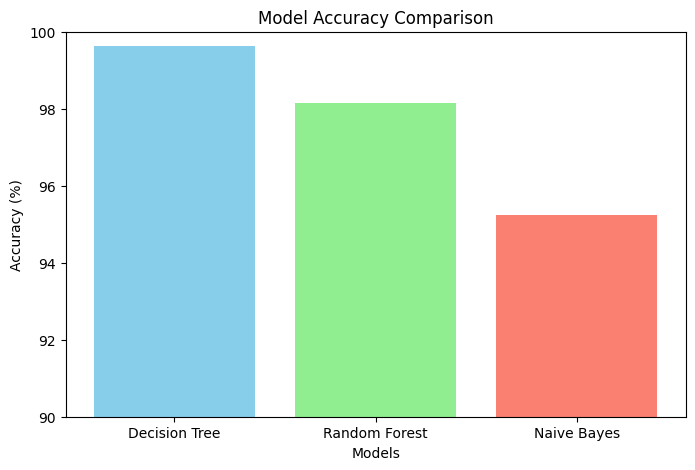

In [22]:
import matplotlib.pyplot as plt

models = ['Decision Tree', 'Random Forest', 'Naive Bayes']
accuracy = [acc_dt*100, acc_rf*100, acc_nb*100]

plt.figure(figsize=(8,5))
plt.bar(models, accuracy, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Models')
plt.ylim(90, 100)
plt.show()

In [23]:
print(type(x_train[0]))


<class 'scipy.sparse._csr.csr_matrix'>


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
x_train, x_test, y_train, y_test = train_test_split(data['cleaned_text'],
													data['class'],
													test_size=0.25)

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

max_len = max([len(seq) for seq in x_train_seq])

x_train_padded = pad_sequences(x_train_seq, maxlen=max_len, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=max_len, padding='post', truncating='post')


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, LeakyReLU
from tensorflow.keras.initializers import he_normal
import tensorflow as tf

model = Sequential()

model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
model.add(Dropout(0.3))

model.add(GRU(256, kernel_initializer=he_normal(), return_sequences=True))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.3))
model.add(GRU(128, kernel_initializer=he_normal(), return_sequences=True))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.3))
model.add(GRU(64, kernel_initializer=he_normal()))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.007),
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history=model.fit(x_train_padded,y_train,epochs=3,validation_data=(x_test_padded,y_test),callbacks=[early_stop])

Epoch 1/3
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 416s 387ms/step - accuracy: 0.8691 - loss: 0.2513 - val_accuracy: 0.9950 - val_loss: 0.0188
Epoch 2/3
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 438s 416ms/step - accuracy: 0.9961 - loss: 0.0176 - val_accuracy: 0.9977 - val_loss: 0.0118
Epoch 3/3
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 406s 382ms/step - accuracy: 0.9954 - loss: 0.0164 - val_accuracy: 0.9967 - val_loss: 0.0161


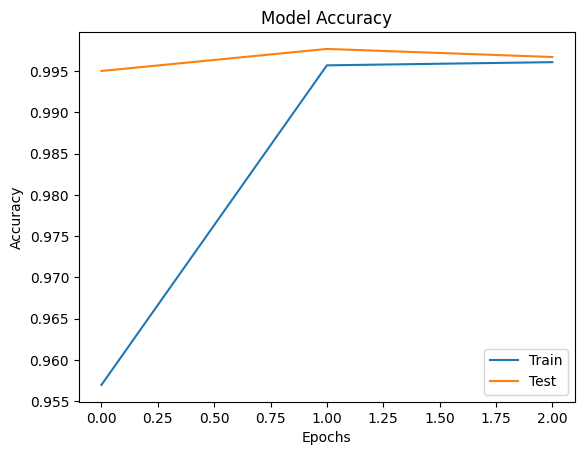

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

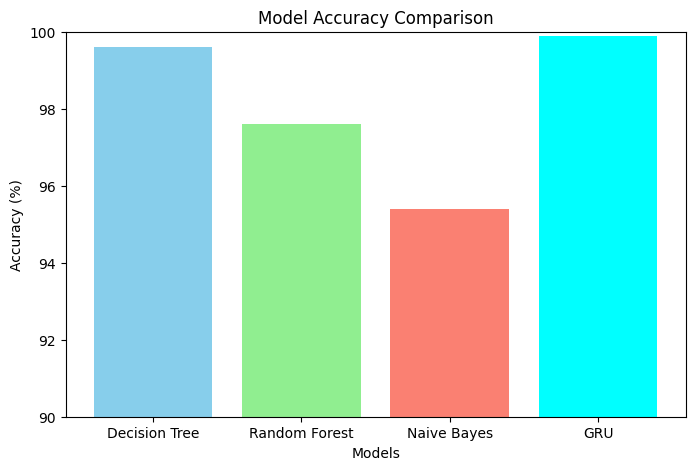

In [29]:
import matplotlib.pyplot as plt

models = ['Decision Tree', 'Random Forest', 'Naive Bayes','GRU']
accuracy = [99.6, 97.6,95.4,99.89]
plt.figure(figsize=(8,5))
plt.bar(models, accuracy, color=['skyblue', 'lightgreen', 'salmon','cyan'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Models')
plt.ylim(90, 100)
plt.show()